# ML-6 Отбор и селекция признаков
###  Содержание <a class="anchor" id=0></a>
- [1. Введение](#1)
- [2. Способы представления данных](#2)
- [3. Кодирование признаков](#3)
- [4. Обработка пропусков и выбросов](#4)
- [5. Масштабирование признаков](#5)
- [6. Трансформации распределений признаков](#6)
- [7. Даты и расстояния](#7)
- [8. Отбор признаков: Мотивация](#8)
- [9. Отбор признаков: Классификация методов](#9)
- [10. Практика](#10)
- [11. Итоги ](#11)

# 2. Способы представления данных <a class="anchor" id=2></a>

1. Числа

2. Не числа (их нахуй)

[к содержанию](#0)

# 3. Кодирование признаков <a class="anchor" id=3></a>

## Можно посмотреть файл `codding.ipynb`

[к содержанию](#0)

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
%%capture
!wget https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

In [3]:
data = pd.read_excel('data_ford_price.xlsx') 
y = data['price']
x = data.drop(columns='price')

Попробуем применить линейную регрессию на «сырых» данных:

In [4]:
lr = LinearRegression()
lr.fit(x,y)

ValueError: could not convert string to float: 'clean'

Мы получим ошибку с комментарием о том, что не удалось превратить строковое значение в число с плавающей точкой (`float`).

Чтобы этой ошибки не возникало, необходимо **закодировать данные.**

<img src=ml6_img1.png>

В таблице ниже представлено сравнение данных способов кодировки:

<img src=ml6_img2.png>

Для реализации данных методов мы использовали библиотеку [category_encoders](https://contrib.scikit-learn.org/category_encoders/). Однако вы уже знаете и такой мощный инструмент, как [scikit-learn](https://scikit-learn.org/). Данная библиотека содержит набор реализованных алгоритмов машинного обучения, метрик для оценки их качества, а также  класс preprocessing для предобработки данных, в частности — для кодирования категориальных признаков.

Представленная ниже таблица показывает соответствие типа кодирования классу в `sklearn.processing`.

<img src=ml6_img3.png>

Преимущество использования одной библиотеки состоит в типичности методов. Например, вы знаете, что для обучения модели в sklearn используется метод `fit()`. При кодировании признаков здесь также применяют `fit()` для подгонки кодировщика под выборку и `transform()` — для преобразования данных в числа.

<img src=ml6_img4.png>

Из предыдущих модулей мы знаем, что при решении задач машинного обучения данные разбираются на обучающую (`train`) и валидационную (`validation`) выборки (последняя также может быть тестовой (`test`) выборкой). По аналогии подгонка кодировщика происходит на обучающей выборке, а трансформация — на обучающей и на тестовой.

Почему так? Потому что наша обученная модель не должна видеть данные, которые подаются в неё на тесте. Только так мы можем судить о том, что модель обучена качественно. То же самое и с кодировкой.

Давайте посмотрим на кодирование признака Образование способом **«один-против-всех»** (`one vs all`):

In [5]:
from sklearn.preprocessing  import LabelBinarizer
 
lb = LabelBinarizer()
 
education = ['нет', 'начальное', 'среднее', 'BSc', 'MSc', 'начальное', 'PhD']
 
lb.fit(education)
 
print('категории:', lb.classes_)
 
lb.transform(['нет', 'MSc'])

категории: ['BSc' 'MSc' 'PhD' 'начальное' 'нет' 'среднее']


array([[0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0]])

У класса `LabelBinarizer`, как и у двух остальных, есть атрибут `classes_`, который выводит список уникальных значений признака.

Вернёмся к нашей выборке. В ней присутствуют следующие категориальные признаки: `condition`, `cylinders`, `title_status`, `transmission`, `drive`, `size`.

При этом, признаки: 
* `condition` и `cylinders` — **числовые**

*  `title_status`, `transmission`, `drive`, `size` —**текстовые**.

<img src=ml6_img5.png>

### Важно производить кодирование номинальных признаков, даже если они уже представлены в числовом формате, так как, в отличие от порядковых признаков, **категории номинальных являются независимыми**. В случае порядкового кодирования таких признаков мы вносим искусственные закономерности в данные (например, чем больше числовой код цилиндров, тем лучше, хотя это необязательно так).

Посмотрим на число уникальных значений номинальных признаков `title_status`, `transmission`, `drive`, `size` и `cylinders`:

In [6]:
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']
 
for column in columns_to_change:
 print('Число уникальных значений признака {}: '.format(column), data[column].nunique())

Число уникальных значений признака cylinders:  6
Число уникальных значений признака title_status:  5
Число уникальных значений признака transmission:  3
Число уникальных значений признака drive:  3
Число уникальных значений признака size:  4


Итак, нам подходит однократное кодирование. Применим его к выбранным столбцам. Так как у нас нет отдельной тестовой выборки, то мы используем только один метод — `fit_transform()`. В качестве аргумента передаём таблицу с выбранными для преобразования признаками.

С помощью метода `get_feature_names()` получим список новых названий колонок:

In [8]:
from sklearn.preprocessing import OneHotEncoder
 
one_hot_encoder = OneHotEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(data[columns_to_change]).toarray()
 
# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names(columns_to_change)
print(column_names)

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

In [12]:
data_new = pd.get_dummies(data)
data_new.shape

(7017, 23)

# 4. Обработка пропусков и выбросов <a class="anchor" id=4></a>

[к содержанию](#0)

## Можно посмотреть `NaNs.ipynb`



In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_excel('data_ford_price.xlsx') 
data.isna().sum()

price              0
year               0
condition          0
cylinders          0
odometer           0
title_status       0
transmission       0
drive            391
size            1564
lat                0
long               0
weather          180
dtype: int64

In [3]:
# Посмотрим, что будет, если просто убрать все строки с пропусками в столбце weather:
data[~data['weather'].isna()]

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
5,6995,2003,3,8,167662,clean,automatic,4wd,full-size,45.518031,-122.578752,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7012,22500,2015,3,6,23500,clean,automatic,rwd,full-size,32.680700,-117.169800,59.0
7013,5975,2005,2,8,0,clean,automatic,rwd,full-size,38.213303,-85.785762,50.0
7014,9999,2006,3,8,161514,clean,automatic,NaN,full-size,37.609783,-120.995406,59.0
7015,10900,2011,2,8,164000,clean,automatic,4wd,full-size,43.140600,-93.385000,47.0


Символ `~ `(тильда) означает, что мы выбираем все строки датасета data, где не выполняется условие `data['weather'].isna()`, то есть где нет пропусков в столбце 'weather'.

In [7]:
# Какая доля строк в датасете останется, если убрать пропуски в столбце size? Ответ округлите до двух знаков после точки-разделителя
round(data[~data['size'].isna()].shape[0] / data.shape[0], 2)

0.78

<img src=ml6_img6.png>

>Первым делом воспользуемся методом удаления строк с пропусками. Плюс данного метода состоит в том, что модель, обученная с удалением всех пропущенных значений, является надёжной, то есть имеет сравнительно хорошее качество на тесте. Среди минусов — потеря большого количества информации, а также плохое качество работы, если процент отсутствующих значений слишком велик по сравнению с полным набором данных.

В качестве регрессора воспользуемся линейной моделью, а качество оценим с помощью коэффициента детерминации. Также нам потребуется разделить модель на обучающую и тестовую выборки.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [9]:
y = data['price']
x = data.drop(columns='price')

In [10]:
# Удалим данные с пропусками:
x = x.dropna()

# Выберем все оставшиеся индексы таблицы x с помощью метода index(), 
# а затем используем .iloc[], чтобы получить подгруппу целевых значений, соответствующую полученным индексам.
y = y.iloc[x.index]

In [12]:
x.shape[0] == y.shape[0]

True

In [13]:
# Разделим выборку на тренировочную и тестовую в соотношении 80/20:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [17]:
# Проведём кодирование OneHot-методом категориальных переменных.
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()

# Зададим имена признаков
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']

# Обучаем энкодер и сразу применяем преобразование к выборке. Результат переводим в массив:
X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()


# Затем применяем полученное преобразование к тестовой выборке. Результат переводим в массив:
X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()

In [20]:
X_train_onehot_df = pd.DataFrame(X_train_onehot)
X_test_onehot_df = pd.DataFrame(X_test_onehot)

Таблица `X_train` содержит рандомные индексы, так как мы разделили выборку на `train` и `test`. Если просто соединить `X_train` и `X_train_onehot_df`, то получится таблица, полная пропусков по причине несовпадения индексов.

In [23]:
X_train = X_train.reset_index().drop(['index'], axis = 1)
X_test = X_test.reset_index().drop(['index'], axis = 1)
 
y_train = y_train.reset_index().drop(['index'], axis = 1)
y_test = y_test.reset_index().drop(['index'], axis = 1)

In [24]:
X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
 
X_train_new = X_train_new.drop(columns=columns_to_change)
X_test_new = X_test_new.drop(columns=columns_to_change)

In [29]:
X_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1041 non-null   int64  
 1   condition  1041 non-null   int64  
 2   odometer   1041 non-null   int64  
 3   lat        1041 non-null   float64
 4   long       1041 non-null   float64
 5   weather    1041 non-null   float64
 6   0          1041 non-null   float64
 7   1          1041 non-null   float64
 8   2          1041 non-null   float64
 9   3          1041 non-null   float64
 10  4          1041 non-null   float64
 11  5          1041 non-null   float64
 12  6          1041 non-null   float64
 13  7          1041 non-null   float64
 14  8          1041 non-null   float64
 15  9          1041 non-null   float64
 16  10         1041 non-null   float64
 17  11         1041 non-null   float64
 18  12         1041 non-null   float64
 19  13         1041 non-null   float64
 20  14      

In [30]:
# Приведём названия признаков к типу str (иначе модель выкидывает ошибку)
X_train_new.columns = X_train_new.columns.astype(str)
X_test_new.columns = X_test_new.columns.astype(str)

In [31]:
# Настало время обучить модель. Для этого создаём объект класса LinearRegression.
lr_model = LinearRegression()

#Обучаем модель по МНК:
lr_model.fit(X_train_new, y_train)

#Делаем предсказание для тренировочной выборки:
y_train_predict = lr_model.predict(X_train_new)

#Делаем предсказание для тестовой выборки:
y_test_predict = lr_model.predict(X_test_new)
print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.647
Test R^2: 0.693


>Теперь давайте попробуем заполнить пропуски константными значениями и обучить модель заново. Плюс такого подхода состоит в том, что мы предотвращаем потерю данных, которая происходит при удалении строк или столбцов. Основной минус — в снижении разброса (разнообразия) признаков.

In [32]:
# Заполним числовой столбец средним значением, округлив его до целого числа:
import numpy as np
 
X_train['weather'] = X_train['weather'].fillna(np.round(np.mean(X_train['weather']),0))
X_test['weather'] = X_test['weather'].fillna(np.round(np.mean(X_train['weather']),0))

Для простоты воспользуемся заполнением наиболее частым значением категориальных признаков. Для этого сначала определим их в наших признаках, использовав комбинацию методов value_counts() и head():

In [33]:
X_train['drive'].value_counts(True).head(1)

4wd    0.736602
Name: drive, dtype: float64

In [34]:
X_train['size'].value_counts(True).head(1)

full-size    0.830089
Name: size, dtype: float64

In [35]:
X_train['size'] = X_train['size'].fillna('full-size')
X_train['drive'] = X_train['drive'].fillna('4wd')
 
X_test['size'] = X_test['size'].fillna('full-size')
X_test['drive'] = X_test['drive'].fillna('4wd')

### После обучения модели получился следующий результат:
### Train R^2: 0.649
### Test R^2: 0.465

>Напомним: модели с коэффициентом детерминации выше 0.8 можно признать достаточно хорошими. Равенство коэффициента детерминации 1 означает, что объясняемая переменная в точности описывается рассматриваемой моделью.

Приведённые методы обработки отсутствующих значений не учитывают корреляционную связь признака, содержащего пропуски, с остальными. Признаки, не имеющие NaN, можно использовать для прогнозирования пропущенных значений. Строится модель регрессии или классификации в зависимости от характера (категорийного или непрерывного) признака, имеющего пропущенное значение.

In [46]:
data = pd.read_excel('data_ford_price.xlsx') 
y = data['price']
x = data.drop(columns='price')

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
 
data = x.copy()
 
test_data = data[data['weather'].isnull()]
data.dropna(inplace=True)
 
y_train = data['weather']
X_train = data.drop(['size','weather','drive'], axis=1)
X_test = test_data.drop(['size','weather','drive'], axis=1)
 
one_hot_encoder = OneHotEncoder()
categorial_cols = ['cylinders', 'title_status', 'transmission']
 
X_train_onehot = one_hot_encoder.fit_transform(X_train[categorial_cols]).toarray()
X_test_onehot = one_hot_encoder.transform(X_test[categorial_cols]).toarray()
 
columns = one_hot_encoder.get_feature_names_out(categorial_cols)
X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)
 
X_train = X_train.reset_index().drop(['index'], axis = 1)
X_test = X_test.reset_index().drop(['index'], axis = 1)
y_train = y_train.reset_index().drop(['index'], axis = 1)
 
X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
 
X_train_new = X_train_new.drop(columns=categorial_cols)
X_test_new = X_test_new.drop(columns=categorial_cols)
 
 
model = LinearRegression()
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)
y_pred.shape

(180, 1)

Полученные предсказания есть не что иное, как замена пропусков в столбце `weather`:

In [49]:
for i, ni in enumerate(test_data.index[:len(x)]):
             x['weather'].loc[ni] = y_pred[i]

/tmp/ipykernel_3337/3939650608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['weather'].loc[ni] = y_pred[i]


In [50]:
x['weather'].isna().sum()

0

In [51]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          5453 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


Данный признак является категориальным. Следовательно, понадобится классификатор для заполения пропусков в нем.

In [53]:
data = x.copy()
 
test_data = data[data['size'].isnull()]
data.dropna(inplace=True)
 
y_train = data['size']
X_train = data.drop(['size', 'drive'], axis=1)
X_test = test_data.drop(['size','drive'], axis=1)

In [55]:
# Функция которая делает хуй знает что
def encode_cat_features(columns_to_change, X_train, X_test, y_train):
  one_hot_encoder = OneHotEncoder()
  X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()
  X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()

  columns = one_hot_encoder.get_feature_names_out(columns_to_change)
  
  X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
  X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)

  X_train = X_train.reset_index().drop(['index'], axis = 1)
  X_test = X_test.reset_index().drop(['index'], axis = 1)
  y_train = y_train.reset_index().drop(['index'], axis = 1)

  X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
  X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
  
  X_train_new = X_train_new.drop(columns=columns_to_change)
  X_test_new = X_test_new.drop(columns=columns_to_change)

  return X_train_new, X_test_new

In [56]:
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

In [58]:
model = LogisticRegression()
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)

for i, ni in enumerate(test_data.index[:len(x)]):
             x['size'].loc[ni] = y_pred[i]

/home/aubakirov/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_3337/1298508494.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['size'].loc[ni] = y_pred[i]


In [59]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


# РАБОТА С ВЫБРОСАМИ

Помимо пропусков, на пути анализа данных всплывает ещё один подводный камень — выбросы (аномалии).

>Выбросы могут искажать статистические показатели и распределения данных. Удаление выбросов из обучающих данных перед моделированием может привести к росту качества прогнозов.
>
>К счастью, существуют автоматические, основанные на моделях методы выявления выбросов, которые уже имплементированы в  `sklearn`.

Посмотрим, как обработка выбросов влияет на качество модели регрессии. В качестве метрики воспользуемся MAE.

Для начала сформируем baseline-модель. Проведём следующую предобработку: для простоты уберём категориальные столбцы из данных и затем удалим строки с пропусками.

In [61]:
data = pd.read_excel('data_ford_price.xlsx') 
data = data[['price', 'year', 'cylinders', 'odometer' ,'lat', 'long', 'weather']]
data.dropna(inplace = True)
 
y = data['price']
x = data.drop(columns='price')
x.head()

,year,cylinders,odometer,lat,long,weather
0,2016,6,43500,36.471500,-82.483400,59.0
1,2009,8,98131,40.468826,-74.281734,52.0
2,2002,8,201803,42.477134,-82.949564,45.0
3,2000,8,170305,40.764373,-82.349503,49.0
5,2003,8,167662,45.518031,-122.578752,50.0


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)

model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4856.318


1. Первый алгоритм, который мы применим, — `Isolation Forest`, или `iForest`. Это алгоритм обнаружения аномалий на основе дерева.

>Данный метод стремится изолировать аномалии, которые немногочисленны и различаются по пространству признаков.

Библиотека `scikit`-`learn` предоставляет реализацию `Isolation` `Forest` в классе `IsolationForest`.

Одним из основных гиперпараметров модели является `contamination` («загрязнение»), который используется для оценки количества выбросов в наборе данных. Его значение находится в диапазоне от 0.0 до 0.5 и по умолчанию равно 0.1.

In [63]:
from  sklearn.ensemble import IsolationForest
 
# ищем выбросы в обучающей выборке
iso = IsolationForest(contamination=0.1)
y_predicted = iso.fit_predict(X_train)
 
# выберем все строки, которые не являются выбросами
mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

/home/aubakirov/.local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(4307, 6) (4307,)
MAE: 4751.723


2. Следующий метод — `Local` `Outlier` `Factor`, или `LOF`. Это метод, который пытается использовать идею ближайших соседей для обнаружения выбросов.

>Каждому примеру присваивается оценка того, насколько он изолирован от его локальных соседей. Примеры, которые наиболее отдалены от соседей, скорее всего, будут являться выбросами.

Библиотека `scikit`-`learn` обеспечивает реализацию этого подхода в классе `LocalOutlierFactor`.

In [64]:
from sklearn.neighbors import LocalOutlierFactor
 
lof = LocalOutlierFactor()
y_predicted = lof.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(4019, 6) (4019,)
MAE: 4762.499


3. Напоследок рассмотрим `Minimum` `Covariance` `Determinant`, или `MCD`.

Если входные переменные имеют гауссово распределение, то для обнаружения выбросов можно использовать простые статистические методы.

Например, если набор данных имеет две входные переменные и обе они являются гауссовыми, то пространство признаков образует многомерную гауссовскую зависимость, и знание этого распределения можно использовать для определения значений, далёких от распределения.

>Этот подход можно обобщить, определив гиперсферу (эллипсоид), которая покрывает нормальные данные, а данные, выходящие за пределы этой формы, считаются выбросами. Эффективная реализация этого метода для многомерных данных известна как детерминант минимальной ковариации (`MCD`).

Библиотека `scikit`-`learn` предоставляет доступ к этому методу через класс `EllipticEnvelope`.

In [65]:
from sklearn.covariance import EllipticEnvelope
 
ee = EllipticEnvelope(contamination=0.01)
y_predicted = ee.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(3978, 6) (3978,)
MAE: 4779.824


>Данные алгоритмы носят стохастический характер, поэтому результаты метрики могут отличатся **от прогона к прогону**.

Мы видим, что оптимальный результат достигается с помощью древовидного алгоритма Isolation Forest, тогда как пространственные методы LOF и MCD принимают за выбросы больше данных, что приводит к ухудшению качества. Тем не менее, все три метода превосходят baseline.

Ниже приведено визуальное сравнение трёх методов на «игрушечных» данных:

<img src=ml6_img7.png>

# 5. Масштабирование признаков <a class="anchor" id=5></a>

[к содержанию](#0)

## `calibrating.ipynb`

>Часто встречаются наборы данных, в которых разные столбцы имеют разные единицы измерения: например, один столбец может быть в килограммах, а другой — в сантиметрах. Кроме того, у нас могут быть такие столбцы, как `price`, который может варьироваться от 1 до 300 000 и даже больше, в то время как столбец `weather` изменяется от 29 до 71 (максимум). Таким образом, `price` примерно в **4000 раз больше, чем `weather`**.

Но как мы можем быть уверены, что модель одинаково обрабатывает обе эти переменные? Когда мы подаём эти признаки в модель как есть, есть все шансы, что `price` больше повлияет на результат предсказания, например, года выпуска автомобиля, из-за большего значения параметра цены. Но это не обязательно означает, что данный параметр более важен как предиктор. Итак, чтобы придать значение как `price`, так и `weather`, нужно **масштабирование признаков**.



In [3]:
data = pd.read_excel('data_ford_price.xlsx') 
data = data[['price', 'year', 'weather']]
data.dropna(inplace = True)
data_scaled = data.copy()
col_names = ['price', 'weather']
x = data_scaled[col_names]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
 
data_scaled[col_names] = scaler.fit_transform(x.values)
data_scaled

,price,year,weather
0,2.558728,2016,0.862068
1,0.067373,2009,-0.017965
2,-1.072197,2002,-0.897998
3,-1.176990,2000,-0.395122
5,-0.677579,2003,-0.269403
...,...,...,...
7012,0.682100,2015,0.862068
7013,-0.767025,2005,-0.269403
7014,-0.414149,2006,0.862068
7015,-0.335138,2011,-0.646560


In [6]:
from sklearn.metrics import mean_absolute_error
y = data_scaled['year']
x = data_scaled.drop(columns='year')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)
 
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 3.041


Отмасштабируйте признак `price` с помощью `RobustScaler`.
В качестве ответа запишите результат выполнения кода `data['price'][1]`. Ответ округлите до двух знаков после точки-разделителя.

In [10]:
data = pd.read_excel('data_ford_price.xlsx') 
data = data[['price', 'year', 'weather']]
data.dropna(inplace = True)
data_scaled = data.copy()
col_names = ['price', 'weather']
x = data_scaled[col_names]

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
 
data_scaled[col_names] = scaler.fit_transform(x.values)
round(data_scaled['price'][1],2)

0.19

# 6. Трансформации распределений признаков <a class="anchor" id=6></a>

[к содержанию](#0)

## `transform.ipynb`

# QUANTILE TRANSFORMER

Этот [метод](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) трансформации признаков преобразует распределение переменной в нормальное или равномерное распределение и масштабирует его соответствующим образом.

Квантильное преобразование сопоставляет распределение вероятностей переменной с другим распределением вероятностей с использованием квантильной функции.

Квантильная функция, также называемая функцией процентной точки (`PPF`), является обратной функцией кумулятивного распределения вероятностей (`CDF`).

* `CDF` — это функция, которая возвращает вероятность значения, равного или меньше заданного значения.

* `PPF` является инверсией этой функции и возвращает значение с заданной вероятностью или ниже неё.

<img src=ml6_img8.png>

Квантильная функция ранжирует или сглаживает взаимосвязь между наблюдениями и может быть отображена на другие распределения (равномерное или нормальное).

Это квантильное преобразование доступно в библиотеке машинного обучения `Python` `scikit`-`learn` через класс `QuantileTransformer`.

У класса есть аргумент `output_distribution`, который может принимать значение '`uniform`' или '`normal`' (по умолчанию — '`uniform`').

Гиперпараметр `n_quantiles` определяет разрешение отображения или ранжирование наблюдений в наборе данных. Это значение должно быть меньше, чем количество наблюдений в наборе данных, и по умолчанию равно `1000`.

Поскольку этот метод изменяет само распределение переменных, из-за этого скейлера линейные отношения между переменными могут быть разрушены. Таким образом, **лучше всего использовать его для нелинейных данных.**

Применим данное преобразование к признаку `year`. Для начала посмотрим на его распределение.

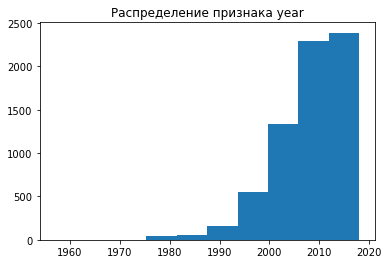

In [11]:
import matplotlib.pyplot as plt
 
plt.hist(data.year)
plt.title('Распределение признака year');

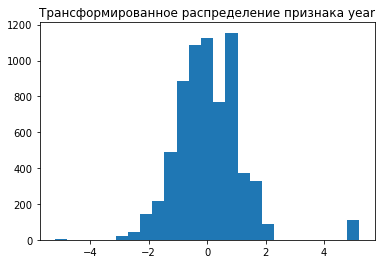

In [12]:
from sklearn.preprocessing import QuantileTransformer
# Данный трансформер принимает на вход 2D-массив, поэтому нам надо изменить формат данных (поскольку что мы подаём на вход только один столбец)
data_for_transform = data['year'].values.reshape((len(data),1))
 
quantile = QuantileTransformer(output_distribution='normal')
data_transformed = quantile.fit_transform(data_for_transform)
 
plt.hist(data_transformed, bins=25)
plt.title('Трансформированное распределение признака year')
plt.show()

Преобразуйте распределение признаков `condition` и `cylinders` в равномерное. Какое значение признака `condition` получится у нулевого объекта? Ответ округлите до второго знака после точки-разделителя.

In [15]:
data = pd.read_excel('data_ford_price.xlsx') 
data = data[['condition', 'cylinders']]
data.dropna(inplace = True)

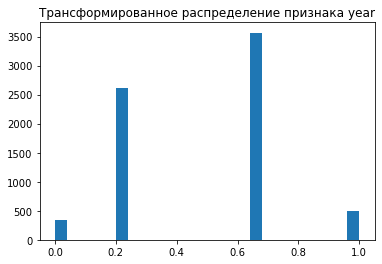

array([0.96396396])

In [21]:
from sklearn.preprocessing import QuantileTransformer
# Данный трансформер принимает на вход 2D-массив, поэтому нам надо изменить формат данных (поскольку что мы подаём на вход только один столбец)
data_for_transform = data['condition'].values.reshape((len(data),1))
 
quantile = QuantileTransformer()
data_transformed = quantile.fit_transform(data_for_transform)
 
plt.hist(data_transformed, bins=25)
plt.title('Трансформированное распределение признака year')
plt.show()
data_transformed[0]

# LOG TRANSFORM

Логарифмическое преобразование — один из самых популярных методов преобразования. В основном оно используется для превращения асимметричного распределения в нормальное/менее асимметричное. В этом преобразовании мы берём логарифм значений признака вместо самих значений.

Почему это работает? Потому, что функция логарифма создана для работы с большими числами.

Посмотрим на распределение признака price. Оно асимметрично, причём значения варьируются от 0 до ~300000.

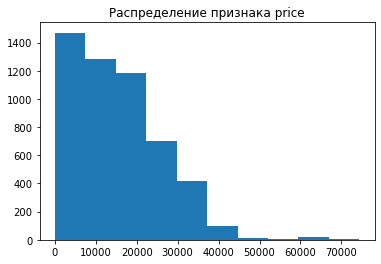

In [22]:
data = pd.read_excel('data_ford_price.xlsx') 

data.dropna(inplace = True)

plt.hist(data.price)
plt.title('Распределение признака price');

Идеальный кандидат для логарифмического преобразования — применим его. На этот раз обойдёмся силами `numpy`.

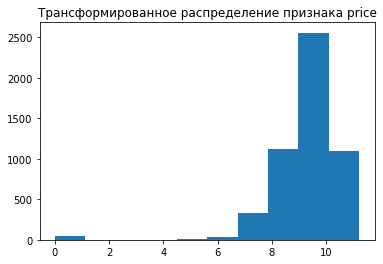

In [23]:
log_price = np.log(data['price'])
 
plt.hist(log_price)
plt.title('Трансформированное распределение признака price')
plt.show()

Давайте также сравним значения исходного и трансформированного признака.

In [24]:
price_data = pd.concat([data['price'], log_price.rename('transformed_price')], axis = 1)
 
price_data.describe()

,price,transformed_price
count,5202.000000,5202.000000
mean,15388.826797,9.254334
std,10820.253885,1.264931
min,1.000000,0.000000
25%,6800.000000,8.824678
50%,13880.000000,9.538204
75%,21995.000000,9.998570
max,74374.000000,11.216862


Теперь вместо экстремального разброса значений в 1 и 299500 мы получили 0 и 12.6. Таким образом, логарифмическое преобразование сыграло роль в уменьшении влияния слишком низких и слишком высоких значений.

>Стоит учесть, что, если наши данные имеют отрицательные значения или значения в диапазоне от 0 до 1, мы не можем применить логарифмическое преобразование напрямую, поскольку логарифм отрицательных чисел и 0 не определён, то есть мы получим ошибки или значения NaN в наших данных. В таких случаях мы можем добавить число к этим значениям, чтобы все они были больше 1.

In [37]:
log_price.tail()

7010    11.050811
7012    10.021271
7013     8.695339
7015     9.296518
7016     9.798127
Name: price, dtype: float64

In [38]:
round(log_price[7016],2)

9.8

# POWER TRANSFORMER SCALER

Как и другие скейлеры, с которыми вы уже познакомились, `Power` `Transformer` также изменяет распределение переменной, то есть делает его более гауссовым (нормальным).

Однако чтобы использовать все изученные раннее методы трансформации и скейлинга, необходимо сначала понять исходное распределение признака, а затем уже делать выбор. `Power` `Transformer` фактически автоматизирует принятие этого решения, вводя параметр, называемый `lambda`. Он принимает решение об обобщённом степенном преобразовании, находя наилучшее значение , используя один из следующих параметрических методов:

* **Преобразование Бокса-Кокса**, которое работает для положительных значений признака.

* **Преобразование Йео-Джонсона**, которое учитывает при расчётах нулевые и отрицательные значения обрабатываемых переменных.

В нашем случае мы будем использовать преобразование Бокса-Кокса, так как все значения положительны.

In [40]:
data = pd.read_excel('data_ford_price.xlsx') 

data.dropna(inplace = True)

from sklearn.preprocessing import PowerTransformer
box_cox = PowerTransformer(method = 'box-cox')
 
data_box_cox = box_cox.fit_transform(data[['price', 'year']].values)
data_box_cox = pd.DataFrame(data_box_cox, columns = ['transformed_price', 'transformed_year'])

/usr/lib/python3/dist-packages/scipy/stats/_morestats.py:913: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/aubakirov/.local/lib/python3.10/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/aubakirov/.local/lib/python3.10/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


# 7. Даты и расстояния <a class="anchor" id=7></a>

[к содержанию](#0)

# 8. Отбор признаков: Мотивация <a class="anchor" id=8></a>

[к содержанию](#0)

# 9. Отбор признаков: Классификация методов <a class="anchor" id=9></a>

[к содержанию](#0)

# 10. Практика <a class="anchor" id=10></a>

[к содержанию](#0)

# 11. Итоги <a class="anchor" id=11></a>

[к содержанию](#0)